**GeekHub 2018-2019 DL**

**Home work 13 Neural Networks**

Kaggle competion: https://www.kaggle.com/c/geekhub-ds-2019-challenge

Kaggle for colab

In [1]:
# import json
# import kaggle

# !mkdir .kaggle
# token = {"username":"philkaua","key":""}
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}
# !chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Import numpy, keras submodules and some other modules

import cv2
import imageio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import random

#from google.colab import drive
from glob import glob
from imgaug import augmenters as iaa
from keras import layers, initializers, optimizers, regularizers
from keras import datasets, models, callbacks, applications, utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


Load data from repository

In [7]:
#!kaggle competitions download -c geekhub-ds-2019-challenge
# !wget https://www.dropbox.com/s/ljcgvyjo95ogjs8/train_labels.csv
# !wget https://www.dropbox.com/s/bn4hedoc1q2tptc/train.zip
# !unzip -q "train.zip"
# !wget https://www.dropbox.com/s/n87ike3hk8ybkio/test.zip
# !unzip -q "test.zip"

File operations - load data

In [8]:
#Train and Test labels

# File operations
PATH_TO_DATA = os.path.abspath(os.curdir)
path_to_files_train = 'train/*'
path_to_files_test = 'test/*'

train_csv_file = pd.read_csv('train_labels.csv')['Category']

file_train = [file for file in glob(path_to_files_train)]
file_test = [file for file in glob(path_to_files_test)]

# Classes
class_names = np.unique(train_csv_file)
class_dict = {class_name:ind for ind, class_name in enumerate(class_names)}

# labels
train_labels = train_csv_file.map(class_dict).values

print(f'Classes:{class_dict}\n')
print(f'Train labels:{train_labels.shape}\n')


for cls, label in class_dict.items():
    print(f'{cls} => {len(np.where(train_labels == label)[0])}')

Classes:{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Train labels:(3026,)

daisy => 536
dandelion => 743
rose => 569
sunflower => 483
tulip => 695


Preprocessing

In [18]:
%%time
# load images
im_size_1 = 128
im_size_2 = 128

labled_images = np.array([image.img_to_array( image.load_img(file, target_size=(im_size_1, im_size_2)) )\
                          for file in sorted(file_train)])
test_images = np.array([image.img_to_array( image.load_img(file, target_size=(im_size_1, im_size_2)) )\
                        for file in sorted(file_test)])

Wall time: 1min 16s


In [13]:
# Scalling image
labled_images_scaled = labled_images / 255.
test_labled_images_scaled = test_images / 255.

# To binary image
labled_images_scaled_binary = np.array([ rgb2gray(imgs) for imgs in labled_images_scaled])
test_labled_images_scaled_binary = np.array([ rgb2gray(imgs) for imgs in labled_images_scaled])

# For colour use
labled_images_scaled_binary = labled_images_scaled
test_labled_images_scaled_binary = test_labled_images_scaled

print(f'Images scaled:{labled_images_scaled.shape}')
print(f'Images scaled binary:{labled_images_scaled_binary.shape}')

Images scaled:(3026, 128, 128, 3)
Images scaled binary:(3026, 128, 128, 3)


Splitting data train, validation, test

In [15]:
X_train, X_test_all, y_train, y_test_all = train_test_split(labled_images_scaled_binary,\
                                                            train_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_all, y_test_all, test_size=0.3, random_state=42)

Image example

Train shape: (2420, 128, 128, 3)
Unique values in labels: [0 1 2 3 4]
Test shape: (182, 128, 128, 3)
Train images min: 0.0 max: 1.0
First image:


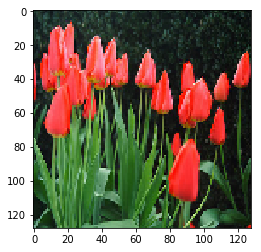

Class for this image: tulip


In [16]:
print("Train shape:", X_train.shape)
print("Unique values in labels:", np.unique(train_labels))
print("Test shape:", X_test.shape)
print("Train images min:", np.min(X_train), "max:", np.max(X_train))

print("First image:")
plt.figure()
plt.imshow(X_train[0], cmap=plt.cm.binary)
plt.grid(False)
plt.show()

print("Class for this image:", class_names[y_train[0]])

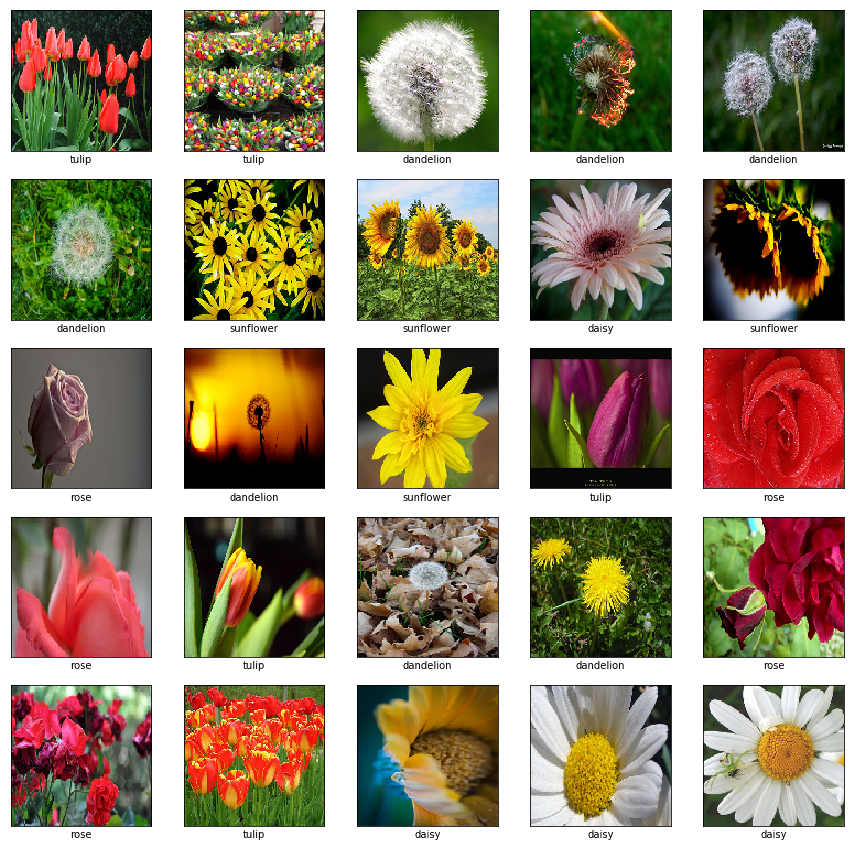

In [17]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

**MODELs**

Danse layers

In [21]:
def getModel(input_shape):
    inp = layers.Input(input_shape)
    flatten = layers.Flatten()(inp) # (batch, width, height) -> (batch, length)
    fc = layers.Dense(75, activation='relu')(flatten)
    fc = layers.Dense(50, activation='relu')(flatten)
    out = layers.Dense(5, activation='softmax')(fc)
    return models.Model(inp, out)
  
model = getModel((im_size_1, im_size_2, 3))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=15,
          epochs=10)

Train on 2420 samples, validate on 424 samples
Epoch 1/10
2420/2420 [==============================] - 6s 2ms/step - loss: 11.3951 - acc: 0.2628 - val_loss: 12.5582 - val_acc: 0.2052
Epoch 2/10
2420/2420 [==============================] - 5s 2ms/step - loss: 10.6887 - acc: 0.3190 - val_loss: 11.6317 - val_acc: 0.2571
Epoch 3/10
2420/2420 [==============================] - 5s 2ms/step - loss: 10.8152 - acc: 0.2967 - val_loss: 10.5722 - val_acc: 0.3019
Epoch 4/10
2420/2420 [==============================] - 6s 2ms/step - loss: 5.6540 - acc: 0.2727 - val_loss: 1.5559 - val_acc: 0.2358
Epoch 5/10
2420/2420 [==============================] - 5s 2ms/step - loss: 1.5677 - acc: 0.2835 - val_loss: 1.5866 - val_acc: 0.2476
Epoch 6/10
2420/2420 [==============================] - 4s 2ms/step - loss: 1.5737 - acc: 0.2674 - val_loss: 1.5526 - val_acc: 0.2736
Epoch 7/10
2420/2420 [==============================] - 5s 2ms/step - loss: 1.5671 - acc: 0.2905 - val_loss: 1.5923 - val_acc: 0.2453
Epoch 8/1

In [22]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 0s 681us/step


[1.5591163242256247, 0.3021978035077944]

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_35 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_36 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 32)        0         
__________

CNN - 3 layers Conv + Dense

In [25]:
def getModel(input_shape):
    
    inp = layers.Input(input_shape)
  
    conv = layers.Conv2D(32, 3, padding='same')(inp) #filters=32, kernel size=3
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(32, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D()(conv) #default pool_size=2
  
    conv = layers.Conv2D(64, 3, padding='same')(pool)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(64, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D()(conv) 
   
    conv = layers.Conv2D(128, 3, padding='same')(pool) 
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(128, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
  
    pool = layers.GlobalMaxPool2D()(conv)  
    fc = layers.Dense(100)(pool)
    fc = layers.Activation('relu')(fc)
    fc = layers.Dense(40, activation='relu')(fc)
    fc = layers.Dense(5)(fc)
    out = layers.Activation('softmax')(fc)
    
    return models.Model(inp, out)

model = getModel((im_size_1, im_size_2, 3))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=15,
          epochs=15
         )

Train on 2420 samples, validate on 424 samples
Epoch 1/15
2420/2420 [==============================] - 15s 6ms/step - loss: 1.4574 - acc: 0.3277 - val_loss: 1.2852 - val_acc: 0.3939
Epoch 2/15
2420/2420 [==============================] - 12s 5ms/step - loss: 1.2060 - acc: 0.4740 - val_loss: 1.1324 - val_acc: 0.5047
Epoch 3/15
2420/2420 [==============================] - 13s 5ms/step - loss: 1.0873 - acc: 0.5492 - val_loss: 1.0051 - val_acc: 0.5873
Epoch 4/15
2420/2420 [==============================] - 12s 5ms/step - loss: 0.9550 - acc: 0.6190 - val_loss: 0.9941 - val_acc: 0.5920
Epoch 5/15
2420/2420 [==============================] - 12s 5ms/step - loss: 0.9226 - acc: 0.6393 - val_loss: 0.9046 - val_acc: 0.6486
Epoch 6/15
2420/2420 [==============================] - 13s 5ms/step - loss: 0.8465 - acc: 0.6653 - val_loss: 0.8603 - val_acc: 0.6557
Epoch 7/15
2420/2420 [==============================] - 13s 5ms/step - loss: 0.8071 - acc: 0.6942 - val_loss: 0.8350 - val_acc: 0.6745
Epoch 8/

In [26]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 1s 6ms/step


[0.7568789373387347, 0.7637362670112442]

CNN - 3 layers Conv + Dropouts + Dense

In [31]:
def getModel(input_shape):
    
    inp = layers.Input(input_shape)
  
    conv = layers.Conv2D(32, (3, 3), padding='same')(inp) #filters=32, kernel size=3
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D(pool_size=(2, 2))(conv) #default pool_size=2
    
    conv = layers.Conv2D(32, (3, 3), padding='same')(pool)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D(pool_size=(2, 2))(conv)
    
    conv = layers.Conv2D(64, (3, 3), padding='same')(pool)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D(pool_size=(2, 2))(conv) 
   
    #pool = layers.GlobalMaxPool2D()(pool)  
            
    flatten = layers.Flatten()(pool)
        
    fc = layers.Dense(40)(flatten)
    fc = layers.Activation('relu')(fc)
    fc = layers.Dropout(0.1)(fc)
    fc = layers.Dense(5)(fc)
    out = layers.Activation('softmax')(fc)
    
    return models.Model(inp, out)

model = getModel((im_size_1, im_size_2, 3))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=15,
          epochs=15
         )

Train on 2420 samples, validate on 424 samples
Epoch 1/15
2420/2420 [==============================] - 10s 4ms/step - loss: 1.4393 - acc: 0.3417 - val_loss: 1.2661 - val_acc: 0.4764
Epoch 2/15
2420/2420 [==============================] - 7s 3ms/step - loss: 1.2235 - acc: 0.4521 - val_loss: 1.2240 - val_acc: 0.4175
Epoch 3/15
2420/2420 [==============================] - 7s 3ms/step - loss: 1.1016 - acc: 0.5231 - val_loss: 1.0304 - val_acc: 0.5873
Epoch 4/15
2420/2420 [==============================] - 8s 3ms/step - loss: 1.0017 - acc: 0.5930 - val_loss: 0.9904 - val_acc: 0.6297
Epoch 5/15
2420/2420 [==============================] - 7s 3ms/step - loss: 0.8841 - acc: 0.6426 - val_loss: 1.0349 - val_acc: 0.5849
Epoch 6/15
2420/2420 [==============================] - 8s 3ms/step - loss: 0.7992 - acc: 0.6690 - val_loss: 0.9839 - val_acc: 0.6132
Epoch 7/15
2420/2420 [==============================] - 8s 3ms/step - loss: 0.7001 - acc: 0.7149 - val_loss: 1.0665 - val_acc: 0.5943
Epoch 8/15
242

In [32]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 0s 1ms/step


[1.6090352915145538, 0.6098901098901099]

In [36]:
#model.summary()

CNN - 3 layers Conv + Dropouts + Dense + Callacks

In [37]:
def getModel(input_shape):
    inp = layers.Input(input_shape)
  
    conv = layers.Conv2D(32, 3, padding='same')(inp) #filters=32, kernel size=3
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(32, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D()(conv) #default pool_size=2
  
    conv = layers.Conv2D(64, 3, padding='same')(pool)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(64, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
    pool = layers.MaxPool2D()(conv) 
  
    conv = layers.Conv2D(128, 3, padding='same')(pool) 
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(128, 3, padding='same')(conv)
    conv = layers.Activation('relu')(conv)
  
    pool = layers.GlobalMaxPool2D()(conv)
    pool = layers.Dropout(0.2)(pool)
    fc = layers.Dense(40)(pool)
    fc = layers.Activation('relu')(fc)
    fc = layers.Dropout(0.1)(fc)
    fc = layers.Dense(5)(fc)
    out = layers.Activation('softmax')(fc)   
    return models.Model(inp, out)
  
model = getModel((im_size_1, im_size_2, 3))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train.reshape(-1, im_size_1, im_size_2, 3), y_train,
          validation_data=(X_val.reshape(-1, im_size_1, im_size_2, 3), y_val),
          batch_size=15,
          epochs=35,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )

model.load_weights('weights.h5') 

Train on 2420 samples, validate on 424 samples
Epoch 1/35
2420/2420 [==============================] - 16s 6ms/step - loss: 1.4667 - acc: 0.3351 - val_loss: 1.2690 - val_acc: 0.3986

Epoch 00001: val_loss improved from inf to 1.26897, saving model to weights.h5
Epoch 2/35
2420/2420 [==============================] - 13s 5ms/step - loss: 1.2895 - acc: 0.4269 - val_loss: 1.2739 - val_acc: 0.4292

Epoch 00002: val_loss did not improve from 1.26897
Epoch 3/35
2420/2420 [==============================] - 13s 5ms/step - loss: 1.2403 - acc: 0.4517 - val_loss: 1.2494 - val_acc: 0.4104

Epoch 00003: val_loss improved from 1.26897 to 1.24945, saving model to weights.h5
Epoch 4/35
2420/2420 [==============================] - 13s 5ms/step - loss: 1.1546 - acc: 0.5174 - val_loss: 1.0723 - val_acc: 0.5542

Epoch 00004: val_loss improved from 1.24945 to 1.07226, saving model to weights.h5
Epoch 5/35
2420/2420 [==============================] - 13s 5ms/step - loss: 1.0707 - acc: 0.5645 - val_loss: 1.1

In [38]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 0s 2ms/step


[0.6623103320598602, 0.6978021951822134]

CNN - BatchNormalization, Callacks , Multi outputmodel

In [40]:
regularization = regularizers.L1L2(0, 1e-4)

def res_block(x):
    count = int(x.shape[-1])
  
    conv = layers.Conv2D(count, 3, padding='same', kernel_regularizer=regularization)(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(count, 3, padding='same', kernel_regularizer=regularization)(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
  
    return layers.add([conv, x])

def strided_res_block(x, filters):
    conv = layers.Conv2D(filters, 3, padding='same', strides=(2,2), kernel_regularizer=regularization)(x)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=regularization)(conv)
    conv = layers.BatchNormalization()(conv)
  
    shortcut = layers.Conv2D(filters, 1, padding='same', strides=(2,2), kernel_regularizer=regularization)(x)
    shortcut = layers.BatchNormalization()(shortcut)
  
    s = layers.add([conv, shortcut])
    s = layers.Activation('relu')(s)
  
    return s

def getModel(input_shape):
    inp = layers.Input(input_shape)
  
    conv = layers.Conv2D(32, 3, padding='same', strides=(2,2), kernel_regularizer=regularization)(inp)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = res_block(conv)
    conv = res_block(conv)
  
    conv = strided_res_block(conv, 64)
    conv = res_block(conv)
  
    out2 = layers.GlobalAveragePooling2D()(conv)
    out2 = layers.Dropout(0.2)(out2)
    out2 = layers.Dense(5, activation='softmax', name='aux_out')(out2)
  
    conv = strided_res_block(conv, 64)
    conv = res_block(conv)
  
    conv = strided_res_block(conv, 128)
    conv = res_block(conv)   
  
    pool = layers.GlobalAveragePooling2D()(conv)
    pool = layers.Dropout(0.1)(pool)
    fc = layers.Dense(50)(pool)
    fc = layers.Activation('relu')(fc)
    fc = layers.Dense(5)(fc)
    out = layers.Activation('softmax', name='out')(fc)
   
    return models.Model(inputs=inp, outputs=[out, out2])
 
model = getModel((im_size_1, im_size_2, 3))


model.compile(optimizer=optimizers.Adam(1e-3), 
              loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
              loss_weights=[1, 0.5],
              metrics=['accuracy'])

model.fit(X_train.reshape(-1, im_size_1, im_size_2, 3), [y_train, y_train],
          validation_data=(X_val.reshape(-1, im_size_1, im_size_2, 3), [y_val, y_val]),
          batch_size=15,
          epochs=25,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, 
                                        save_best_only=True, save_weights_only=True,
                                        monitor='val_out_loss'),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1, monitor='val_out_loss'),
              callbacks.EarlyStopping(patience=5, verbose=1, monitor='val_out_loss')
          ]
         )

model.load_weights('weights.h5') 

Train on 2420 samples, validate on 424 samples
Epoch 1/25
2420/2420 [==============================] - 43s 18ms/step - loss: 2.2133 - out_loss: 1.3634 - aux_out_loss: 1.4352 - out_acc: 0.4219 - aux_out_acc: 0.4112 - val_loss: 2.2922 - val_out_loss: 1.4218 - val_aux_out_loss: 1.4745 - val_out_acc: 0.4458 - val_aux_out_acc: 0.4481

Epoch 00001: val_out_loss improved from inf to 1.42178, saving model to weights.h5
Epoch 2/25
2420/2420 [==============================] - 30s 13ms/step - loss: 1.8798 - out_loss: 1.1416 - aux_out_loss: 1.2102 - out_acc: 0.5277 - aux_out_acc: 0.5153 - val_loss: 4.0521 - val_out_loss: 3.0708 - val_aux_out_loss: 1.6965 - val_out_acc: 0.2925 - val_aux_out_acc: 0.3962

Epoch 00002: val_out_loss did not improve from 1.42178
Epoch 3/25
2420/2420 [==============================] - 30s 13ms/step - loss: 1.6953 - out_loss: 1.0216 - aux_out_loss: 1.0812 - out_acc: 0.5988 - aux_out_acc: 0.5835 - val_loss: 3.5485 - val_out_loss: 2.7281 - val_aux_out_loss: 1.3756 - val_out

2420/2420 [==============================] - 30s 12ms/step - loss: 1.2351 - out_loss: 0.6737 - aux_out_loss: 0.8664 - out_acc: 0.7558 - aux_out_acc: 0.6773 - val_loss: 1.3166 - val_out_loss: 0.7518 - val_aux_out_loss: 0.8732 - val_out_acc: 0.7123 - val_aux_out_acc: 0.6627

Epoch 00022: val_out_loss improved from 0.75379 to 0.75178, saving model to weights.h5
Epoch 23/25
2420/2420 [==============================] - 30s 12ms/step - loss: 1.2326 - out_loss: 0.6651 - aux_out_loss: 0.8787 - out_acc: 0.7574 - aux_out_acc: 0.6558 - val_loss: 1.3195 - val_out_loss: 0.7547 - val_aux_out_loss: 0.8733 - val_out_acc: 0.7005 - val_aux_out_acc: 0.6580

Epoch 00023: val_out_loss did not improve from 0.75178
Epoch 24/25
2420/2420 [==============================] - 30s 12ms/step - loss: 1.2555 - out_loss: 0.6827 - aux_out_loss: 0.8893 - out_acc: 0.7632 - aux_out_acc: 0.6661 - val_loss: 1.3158 - val_out_loss: 0.7512 - val_aux_out_loss: 0.8730 - val_out_acc: 0.7099 - val_aux_out_acc: 0.6651_loss: 0.6783 

In [41]:
# predicting for submission images
predict = model.predict(test_labled_images_scaled_binary)[0]
np.argmax(predict, axis=-1)

array([4, 1, 1, ..., 2, 2, 0], dtype=int64)

ResNet50

In [0]:
model = applications.ResNet50(weights=None, input_shape=(im_size_1, im_size_2, 3), classes=5)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=15,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ])

In [0]:
model.evaluate(X_test, y_test)

122/122 [==============================] - 1s 8ms/step


[0.9090315592093546, 0.647540982629432]

ResNet50 + frozen Dense layer + preload weights

In [0]:
X_train = X_train*2-1
X_val = X_val*2-1
X_test = X_test*2-1

In [44]:
#pretrained model without top layer
base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(im_size_1, im_size_2, 3),\
                                   pooling='avg')
#fix weights
base_model.trainable = False

#and our model become simple
inp = layers.Input((im_size_1, im_size_2, 3))
resnet = base_model(inp)

fc = layers.Dense(5)(resnet)
fc = layers.Activation('softmax')(fc)

model = models.Model(inp, fc)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#train only dense layer on top
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=1,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )


#unfreeze all weights and train 
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=16,
          epochs=30,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ]
         )

Train on 2420 samples, validate on 484 samples
Epoch 1/1
2420/2420 [==============================] - 32s 13ms/step - loss: 0.8733 - acc: 0.6657 - val_loss: 1.6767 - val_acc: 0.1756

Epoch 00001: val_loss improved from inf to 1.67665, saving model to weights.h5
Train on 2420 samples, validate on 484 samples
Epoch 1/30
2420/2420 [==============================] - 83s 34ms/step - loss: 0.5234 - acc: 0.8149 - val_loss: 0.6483 - val_acc: 0.8326

Epoch 00001: val_loss improved from inf to 0.64834, saving model to weights.h5
Epoch 2/30
2420/2420 [==============================] - 52s 22ms/step - loss: 0.1411 - acc: 0.9595 - val_loss: 0.4902 - val_acc: 0.8698

Epoch 00002: val_loss improved from 0.64834 to 0.49019, saving model to weights.h5
Epoch 3/30
2420/2420 [==============================] - 53s 22ms/step - loss: 0.0541 - acc: 0.9888 - val_loss: 0.4151 - val_acc: 0.8926

Epoch 00003: val_loss improved from 0.49019 to 0.41513, saving model to weights.h5
Epoch 4/30
2420/2420 [=============

In [45]:
model.evaluate(X_test, y_test)

122/122 [==============================] - 2s 13ms/step


[0.3799022885619617, 0.8606557337964167]

ResNet50 + frozen Dense layer + preload weights + Augment images

In [0]:
class AugmentedSequence(utils.Sequence):
    def __init__(self, X, y, batch_size):
        self.X = np.array(X)
        self.y = np.array(y)
        self.batch_size = batch_size
    
        #for shuffling
        self.ids = np.random.permutation(range(len(X)))
    
        #for augmentation
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(scale=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotate=(-15, 15))
            ])
    
    def __len__(self):
        return int(np.ceil(len(self.X)/float(self.batch_size)))
  
    def __getitem__(self, index):
        start = index * self.batch_size
        end = np.minimum((index + 1) * self.batch_size, len(self.X))
    
        ids = self.ids[start:end]
    
        batchX = self.X[ids]
        batchy = self.y[ids]
    
        batchX = self.seq.augment_images(batchX)
    
        return np.array(batchX), np.array(batchy)
  
    def on_epoch_end(self):    
        self.ids = np.random.permutation(range(len(self.X)))

Model 1

In [13]:
#pretrained model without top layer
base_model = applications.ResNet50(include_top=False, weights='imagenet',\
                                   input_shape=(im_size_1, im_size_2, 3), pooling='avg')
#fix weights
base_model.trainable = False

#and our model become simple
inp = layers.Input((im_size_1, im_size_2, 3))
resnet = base_model(inp)
fc = layers.Dense(100)(resnet)
fc = layers.Dense(5)(fc)
fc = layers.Activation('softmax')(fc)

model = models.Model(inp, fc)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

generator = AugmentedSequence(X_train, y_train, 16)

#train only dense layer on top
model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=1,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ])

#unfreeze all weights and train 
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=30,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ])

Epoch 1/1
152/152 [==============================] - 32s 212ms/step - loss: 0.8521 - acc: 0.6875 - val_loss: 2.0746 - val_acc: 0.2052

Epoch 00001: val_loss improved from inf to 2.07461, saving model to weights.h5
Epoch 1/30
152/152 [==============================] - 97s 636ms/step - loss: 0.4922 - acc: 0.8162 - val_loss: 0.4839 - val_acc: 0.8443

Epoch 00001: val_loss improved from inf to 0.48393, saving model to weights.h5
Epoch 2/30
152/152 [==============================] - 82s 539ms/step - loss: 0.3028 - acc: 0.8960 - val_loss: 0.4810 - val_acc: 0.8491

Epoch 00002: val_loss improved from 0.48393 to 0.48098, saving model to weights.h5
Epoch 3/30
152/152 [==============================] - 82s 541ms/step - loss: 0.2273 - acc: 0.9227 - val_loss: 0.3255 - val_acc: 0.8821

Epoch 00003: val_loss improved from 0.48098 to 0.32547, saving model to weights.h5
Epoch 4/30
152/152 [==============================] - 81s 535ms/step - loss: 0.2139 - acc: 0.9317 - val_loss: 0.4332 - val_acc: 0.865

In [14]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 3s 17ms/step


[0.4416547217866877, 0.9120879101229238]

Model 2 (modified frozen layers)

In [20]:
#pretrained model without top layer
base_model = applications.ResNet50(include_top=False, weights='imagenet',\
                                   input_shape=(im_size_1, im_size_2, 3), pooling='avg')
#fix weights
base_model.trainable = False

#and our model become simple
inp = layers.Input((im_size_1, im_size_2, 3))
resnet = base_model(inp)

fc = layers.Dense(128)(resnet)
fc = layers.Activation('relu')(fc)
fc = layers.Dropout(0.1)(fc)

fc = layers.Dense(64)(fc)
fc = layers.Activation('relu')(fc)
fc = layers.Dropout(0.1)(fc)

fc = layers.Dense(5)(fc)
fc = layers.Activation('softmax')(fc)

model = models.Model(inp, fc)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

generator = AugmentedSequence(X_train, y_train, 16)

#train only dense layer on top
model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=10,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ])

#unfreeze all weights and train 
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-4), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit_generator(generator,
          validation_data=(X_val, y_val),
          epochs=30,
          callbacks=[
              callbacks.ModelCheckpoint('weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
              callbacks.ReduceLROnPlateau(patience=2, verbose=1),
              callbacks.EarlyStopping(patience=4, verbose=1)
          ])

Epoch 1/10
152/152 [==============================] - 39s 253ms/step - loss: 0.8770 - acc: 0.6641 - val_loss: 1.7040 - val_acc: 0.1557

Epoch 00001: val_loss improved from inf to 1.70399, saving model to weights.h5
Epoch 2/10
152/152 [==============================] - 23s 154ms/step - loss: 0.6102 - acc: 0.7763 - val_loss: 1.7213 - val_acc: 0.2358

Epoch 00002: val_loss did not improve from 1.70399
Epoch 3/10
152/152 [==============================] - 23s 153ms/step - loss: 0.5209 - acc: 0.8133 - val_loss: 1.6877 - val_acc: 0.2311

Epoch 00003: val_loss improved from 1.70399 to 1.68773, saving model to weights.h5
Epoch 4/10
152/152 [==============================] - 23s 153ms/step - loss: 0.4820 - acc: 0.8244 - val_loss: 1.7594 - val_acc: 0.2052

Epoch 00004: val_loss did not improve from 1.68773
Epoch 5/10
152/152 [==============================] - 23s 151ms/step - loss: 0.4336 - acc: 0.8372 - val_loss: 1.8029 - val_acc: 0.2406

Epoch 00005: val_loss did not improve from 1.68773

Epoc

In [21]:
model.evaluate(X_test, y_test)

182/182 [==============================] - 2s 8ms/step


[0.36227304152734985, 0.9010988991339128]

Predictions and submission

In [35]:
# Predioction
predict = model.predict(test_labled_images_scaled_binary)
labels_predict = np.argmax(predict, axis=-1)
# from sklearn.metrics import accuracy_score
# print(accuracy_score(labels_predict, y_test))


# ID and Categorial labels
labels_id = range(3026,3026+len(labels_predict))
class_dict_submission = {v:k for k, v in class_dict.items()}
labels_predict_kategorial = pd.Series(labels_predict).map(class_dict_submission).values

# Save to csv
sub = pd.DataFrame({'Id':labels_id, 'Category':labels_predict_kategorial})
sub = sub[['Id','Category']]
sub.to_csv('submission.csv', index=False)

#!kaggle competitions submit -c geekhub-ds-2019-challenge -f submission.csv -m "11 try ResNet50 + 200 sizes + frozen dense layer(mod)+Augmented"